In [32]:
#import libraries
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import scipy.io
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math
from scipy.sparse import csr_matrix

In [2]:
# read in the data
df = scipy.io.loadmat('mnist_10digits.mat')
df

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Oct 13 20:00:03 2020',
 '__version__': '1.0',
 '__globals__': [],
 'xtrain': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'ytrain': array([[5, 0, 4, ..., 5, 6, 8]]),
 'xtest': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'ytest': array([[7, 2, 1, ..., 4, 5, 6]])}

In [3]:
# split into respective datasets

X_train = df['xtrain']
y_train = df['ytrain'].T
X_test = df['xtest']
y_test = df['ytest'].T

In [4]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [5]:
# standardize feature vals by dividing by 255
X_train = X_train/255.00
X_test = X_test/255.00

In [10]:
y_train.ravel()

array([5, 0, 4, ..., 5, 6, 8])

In [12]:
# downsample for KNN and SVM
X_train_downsampled, _, y_train_downsampled, _ = train_test_split(
    X_train, y_train, train_size=5000, stratify=y_train, random_state=42
)

In [14]:
y_train_downsampled

array([[1],
       [7],
       [7],
       ...,
       [4],
       [0],
       [5]])

In [20]:
# KKN, find best value of K

param_grid = {'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30, 40, 50],
              'metric': ['euclidean', 'manhattan'],
                'weights': ['uniform', 'distance']}

grid_search_knn = GridSearchCV(estimator = KNeighborsClassifier(), 
                           param_grid = param_grid, 
                           cv = 5,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           verbose = 1)

grid_search_knn.fit(X_train_downsampled, y_train_downsampled.ravel())

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 10, 15, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [21]:
# print best results from training set

best_knn = grid_search_knn.best_estimator_
print("Best KNN parameters:", grid_search_knn.best_params_)

Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [22]:
# calculate on test set
y_pred_best_knn = best_knn.predict(X_test)


In [24]:
# SVM: Linear
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100]}

grid_search_svm = GridSearchCV(estimator=SVC(kernel = 'linear', random_state = 42, verbose = True), 
                                param_grid = param_grid_svm,  
                               cv=5,        
                               scoring='accuracy',  
                               n_jobs=-1,   
                               verbose=2)

grid_search_svm.fit(X_train_downsampled, y_train_downsampled.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LibSVM]

GridSearchCV(cv=5,
             estimator=SVC(kernel='linear', random_state=42, verbose=True),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=2)

In [25]:
best_svm = grid_search_svm.best_estimator_
print("Best SVM parameters:", grid_search_svm.best_params_)

Best SVM parameters: {'C': 0.1}


In [26]:

y_pred_best_svm = best_svm.predict(X_test)

In [27]:
# SVM: RBF
param_grid_rbf = {'C': [0.01, 0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1]}

grid_search_rbf = GridSearchCV(estimator=SVC(kernel = 'rbf', random_state = 42, verbose = True), 
                                param_grid = param_grid_rbf,  
                               cv=5,        
                               scoring='accuracy',  
                               n_jobs=-1,   
                               verbose=2)

grid_search_rbf.fit(X_train_downsampled, y_train_downsampled.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LibSVM]

GridSearchCV(cv=5, estimator=SVC(random_state=42, verbose=True), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='accuracy', verbose=2)

In [28]:
best_rbf = grid_search_rbf.best_estimator_
print("Best SVM RBF parameters:", grid_search_rbf.best_params_)

Best SVM RBF parameters: {'C': 10, 'gamma': 0.01}


In [29]:
y_pred_best_rbf = best_rbf.predict(X_test)

In [30]:
# Logistic regression
lgm = LogisticRegression(random_state = 42, verbose = True, max_iter=500)
lgm.fit(X_train, y_train.ravel())
y_pred_lgm = lgm.predict(X_test)

In [36]:
# Neural Network
mlp = MLPClassifier(hidden_layer_sizes = (20, 10), random_state = 42, verbose = True, max_iter = 500, learning_rate_init = 0.01, learning_rate = 'adaptive', solver= 'sgd')
mlp.fit(X_train, y_train.ravel())
y_pred_mlp = mlp.predict(X_test)

Iteration 1, loss = 1.02796745
Iteration 2, loss = 0.43243484
Iteration 3, loss = 0.34216001
Iteration 4, loss = 0.28658031
Iteration 5, loss = 0.25070260
Iteration 6, loss = 0.22619403
Iteration 7, loss = 0.20872101
Iteration 8, loss = 0.19553014
Iteration 9, loss = 0.18465647
Iteration 10, loss = 0.17682176
Iteration 11, loss = 0.17001340
Iteration 12, loss = 0.16315213
Iteration 13, loss = 0.15829079
Iteration 14, loss = 0.15333191
Iteration 15, loss = 0.14964293
Iteration 16, loss = 0.14636923
Iteration 17, loss = 0.14262559
Iteration 18, loss = 0.13978835
Iteration 19, loss = 0.13630477
Iteration 20, loss = 0.13366155
Iteration 21, loss = 0.13134507
Iteration 22, loss = 0.12859122
Iteration 23, loss = 0.12671514
Iteration 24, loss = 0.12455633
Iteration 25, loss = 0.12237965
Iteration 26, loss = 0.12088673
Iteration 27, loss = 0.11877887
Iteration 28, loss = 0.11711562
Iteration 29, loss = 0.11523124
Iteration 30, loss = 0.11487122
Iteration 31, loss = 0.11286807
Iteration 32, los

In [42]:
# define function to return relevant scores for a given model
def return_scores(predictions, ground_truth, model_name):
    
    # Precision, Recall, F1-score for each class
    precision = precision_score(ground_truth, predictions, average=None)  
    recall = recall_score(ground_truth, predictions, average=None)        
    f1 = f1_score(ground_truth, predictions, average=None)    
    
    # Create a DataFrame for easier visualization
    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, index=[str(i) for i in range(10)])
    
    return metrics_df

### Metrics for each Classifier

In [44]:
scores_svm = return_scores(y_pred_best_svm, y_test, "SVM: Linear")
scores_svm

,Precision,Recall,F1-Score
0,0.936832,0.983673,0.959681
1,0.956373,0.985022,0.970486
2,0.925743,0.906008,0.915769
3,0.884652,0.918812,0.901408
4,0.910521,0.942974,0.926463
5,0.890315,0.855381,0.872499
6,0.945361,0.957203,0.951245
7,0.940535,0.923152,0.931762
8,0.918860,0.860370,0.888653
9,0.925358,0.896928,0.910921


In [45]:
scores_svm_rbf = return_scores(y_pred_best_rbf, y_test, "SVM: RBF")
scores_svm_rbf

,Precision,Recall,F1-Score
0,0.965139,0.988776,0.976815
1,0.974848,0.990308,0.982517
2,0.959804,0.948643,0.954191
3,0.927481,0.962376,0.944606
4,0.961224,0.959267,0.960245
5,0.959584,0.931614,0.945392
6,0.967842,0.973904,0.970864
7,0.964567,0.953307,0.958904
8,0.961094,0.938398,0.949610
9,0.942886,0.932607,0.937718


In [46]:
scores_knn = return_scores(y_pred_best_knn, y_test, "KNN: Best Params")
scores_knn

,Precision,Recall,F1-Score
0,0.949070,0.988776,0.968516
1,0.917886,0.994714,0.954757
2,0.982143,0.906008,0.942540
3,0.922255,0.939604,0.930848
4,0.957974,0.905295,0.930890
5,0.930023,0.923767,0.926884
6,0.962129,0.981211,0.971576
7,0.923892,0.932879,0.928364
8,0.970252,0.870637,0.917749
9,0.879812,0.928642,0.903568


In [47]:
scores_lgm = return_scores(y_pred_lgm, y_test, "LGM")
scores_lgm

,Precision,Recall,F1-Score
0,0.952286,0.977551,0.964753
1,0.962738,0.978855,0.970730
2,0.928215,0.902132,0.914988
3,0.905512,0.910891,0.908193
4,0.936928,0.937882,0.937405
5,0.895402,0.873318,0.884222
6,0.942089,0.950939,0.946494
7,0.934975,0.923152,0.929026
8,0.882474,0.878850,0.880658
9,0.911417,0.917740,0.914568


In [48]:
scores_mlp = return_scores(y_pred_mlp, y_test, "MLP")
scores_mlp

,Precision,Recall,F1-Score
0,0.948156,0.970408,0.959153
1,0.973822,0.983260,0.978518
2,0.945259,0.937016,0.941119
3,0.916587,0.946535,0.931320
4,0.935743,0.949084,0.942366
5,0.921700,0.923767,0.922732
6,0.959916,0.949896,0.954879
7,0.965932,0.937743,0.951629
8,0.923958,0.910678,0.917270
9,0.945399,0.926660,0.935936


### Confusion Matrices for each Classifier

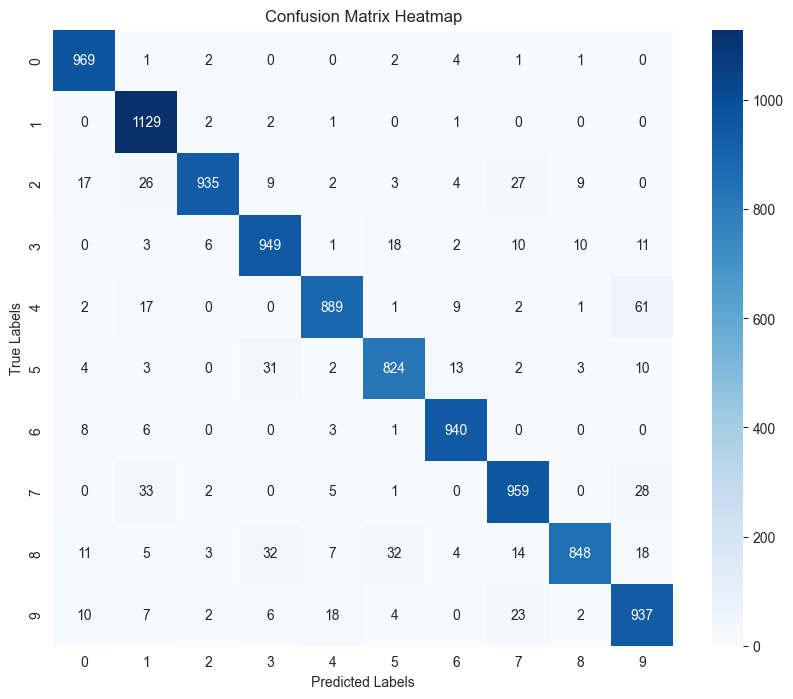

In [57]:
cm_knn = confusion_matrix(y_test, y_pred_best_knn, labels=best_knn.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))

plt.title(f'Confusion Matrix Heatmap KNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

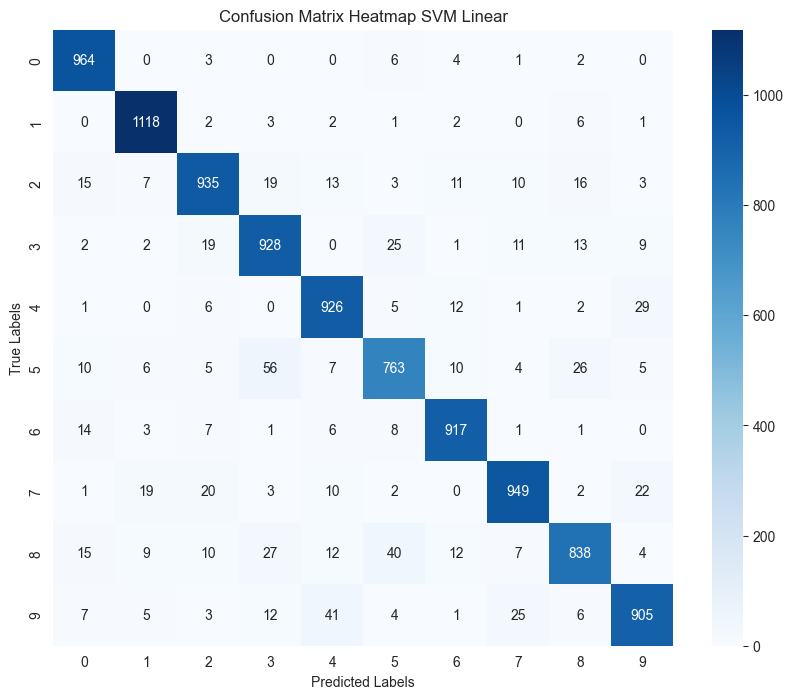

In [58]:
cm_svm = confusion_matrix(y_test, y_pred_best_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))

plt.title(f'Confusion Matrix Heatmap SVM Linear')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

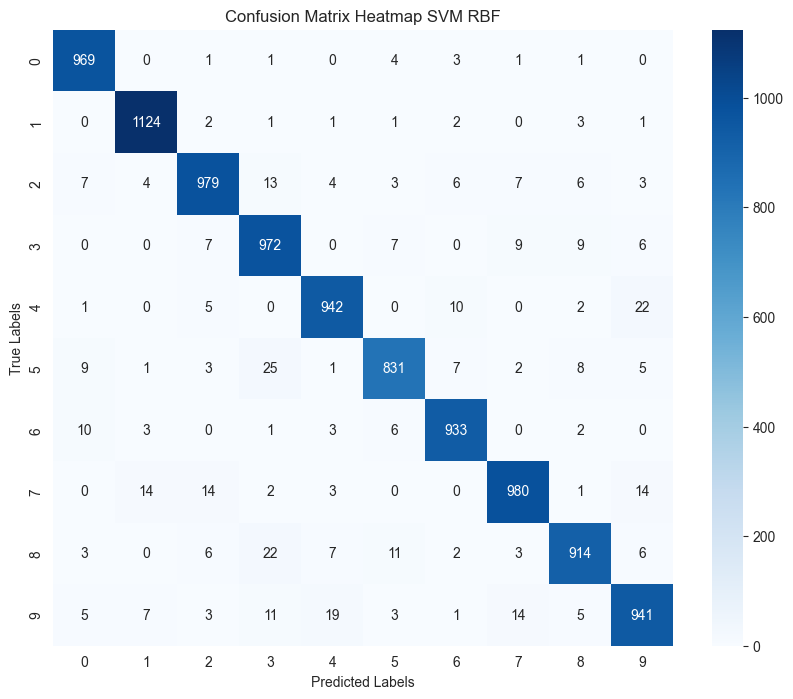

In [59]:
cm_svm_rbf = confusion_matrix(y_test, y_pred_best_rbf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm_rbf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))

plt.title(f'Confusion Matrix Heatmap SVM RBF')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

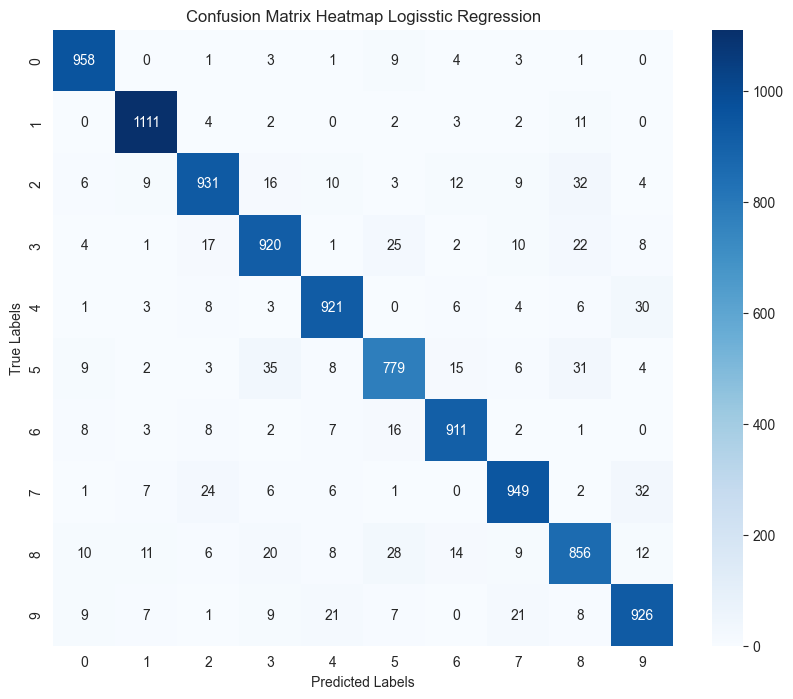

In [60]:
cm_lgm = confusion_matrix(y_test, y_pred_lgm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lgm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))

plt.title(f'Confusion Matrix Heatmap Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

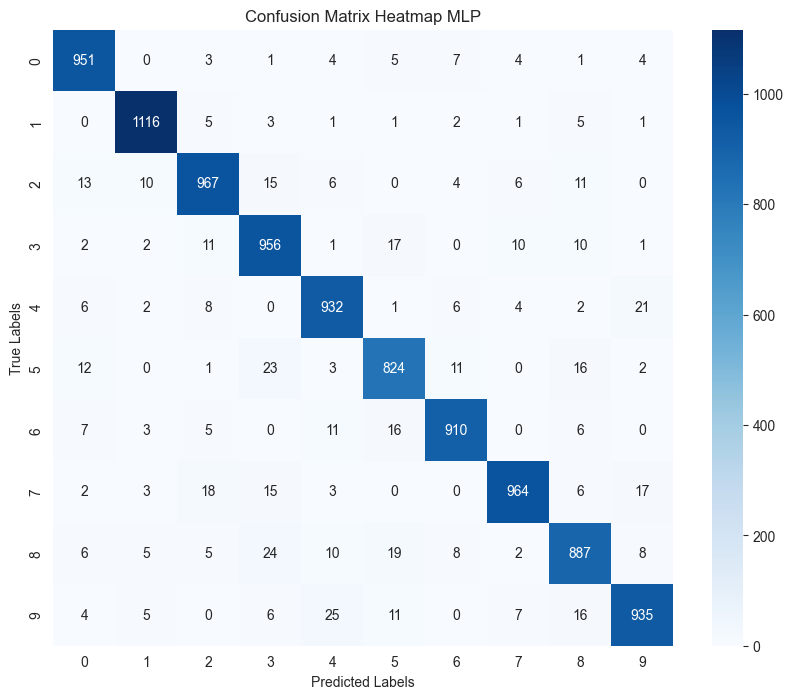

In [61]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))

plt.title(f'Confusion Matrix Heatmap MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# CUSUM

In [3]:
# generate your random variates
seed = 6740
np.random.seed(seed)

f_0 = np.random.normal(0,1,100)
f_1 = np.random.normal(0,np.sqrt(1.5),50)

In [5]:
sample_x = []

sample_x.extend(f_0.tolist())
sample_x.extend(f_1.tolist())

print(sample_x)

[0.6639322853488808, -0.44686525435894686, 0.3074010007967925, 0.6358506527099638, 1.4258701948887773, 0.2612274535001641, 0.2713298360767469, 1.483503011387785, -0.8847789246100903, -0.8568504839193658, -0.17135700672210855, 0.043060325646223016, 0.3074422660594452, -0.9904778989591045, 0.5570866881898758, -1.179218487618933, 1.2437639782498837, -0.8078956334711676, -0.8724605862417116, 1.9549091666557306, 0.48955916855465453, 0.7687440754773931, 0.3880101818306401, 0.08851809231009154, 0.8871826430309353, 1.9143152711129336, 2.1353494321170654, -0.770101351694955, -1.6486471444591562, -2.2276246363246153, 1.0601171831310143, 1.4940088340343474, 0.38902826026751547, -0.2631482707183028, 1.2234710876209312, -0.10452682716448271, -0.021536955434092096, 0.33416982703486026, 0.9145701685618959, 1.5582813499209995, -0.7204691926968025, -0.891369835245648, -0.3930876123378343, 0.36132616440459253, 0.4368380320844742, -1.1838535133751247, -2.1215341156055847, -1.3665673263512799, 0.734765892

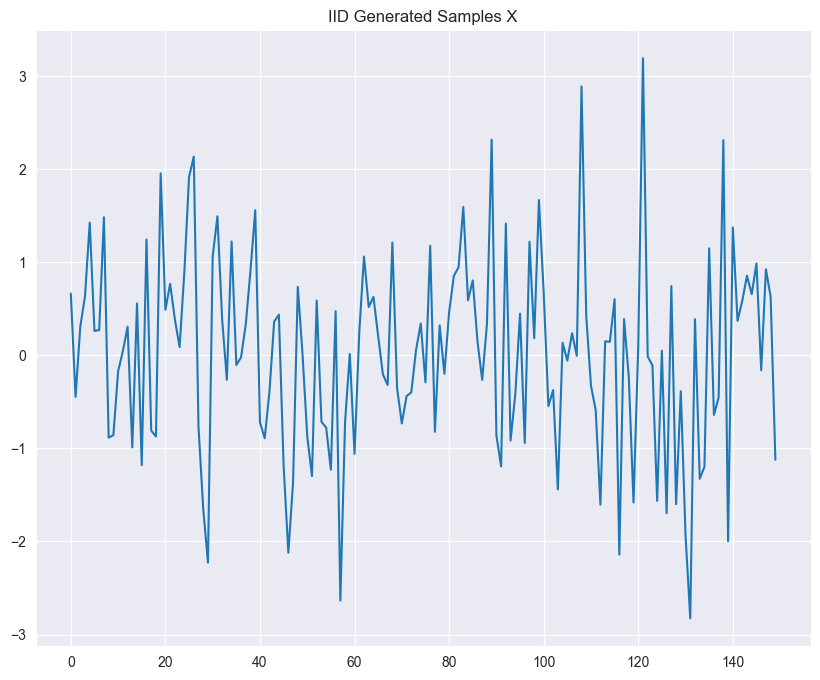

In [6]:
# plot the generated X vlues
plt.figure(figsize=(10, 8))
plt.plot(sample_x)
plt.title("IID Generated Samples X")
plt.show()

In [19]:
# calculate CUSUM

def calculate_weight(x):
    pdf_f0 = norm(0,1).pdf(x)
    pdf_f1 = norm(0,np.sqrt(1.5)).pdf(x)
    
    return math.log(pdf_f1/pdf_f0)

weights = [0]

for i in range(1, len(sample_x)):
    weight = max(weights[i - 1] + calculate_weight(sample_x[i]), 0)
    weights.append(weight)
    


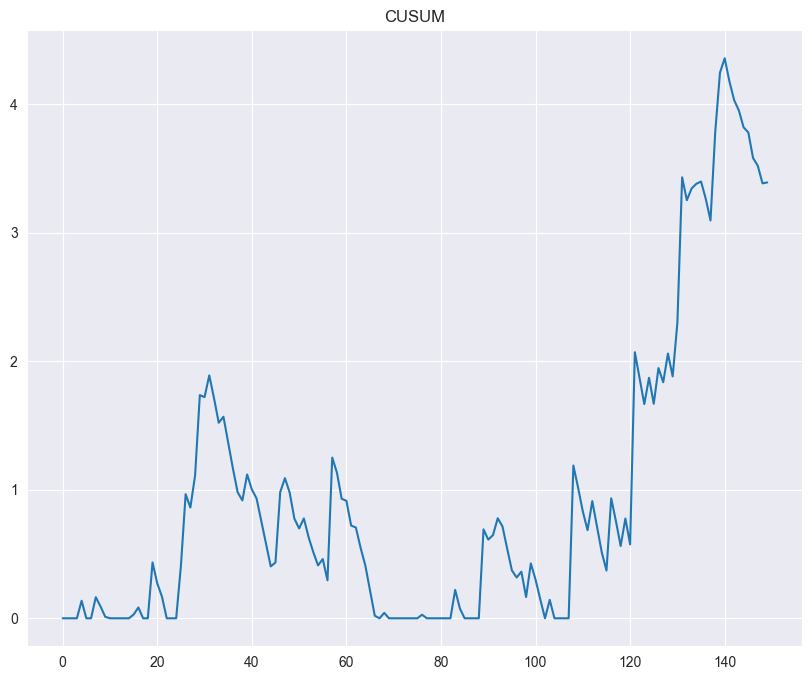

In [20]:
# plot the CUSUM
plt.figure(figsize=(10, 8))
plt.plot(weights)
plt.title("CUSUM")
plt.show()

In [10]:
len(sample_x)

150

# Medical Image Reconstruction

In [3]:
# read in the necessary data
mdi = scipy.io.loadmat('cs.mat')['img'].reshape(2500,)
image_true = mdi.reshape((50, 50))

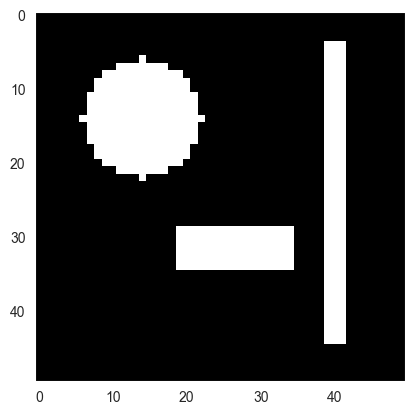

In [47]:
plt.imshow(image_true, cmap = 'gray')
plt.grid(False)


In [17]:
n = 1300
p = 2500
A = np.random.normal(0, 1, (n, p))  
epsilon = np.random.normal(0, np.sqrt(25), n)  
y = A.dot(mdi) + epsilon

In [18]:
alphas = np.logspace(-4, 2, 50)

In [38]:
lasso = Lasso(random_state = 6740)
lasso_cv = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=10, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 2)
lasso_cv.fit(A, y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, estimator=Lasso(random_state=6740), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error', verbose=2)

In [39]:
best_alpha_lasso = lasso_cv.best_params_['alpha']
x_lasso = lasso_cv.best_estimator_.coef_
image_lasso = x_lasso.reshape((50, 50))
mean_test_error = -lasso_cv.cv_results_['mean_test_score']

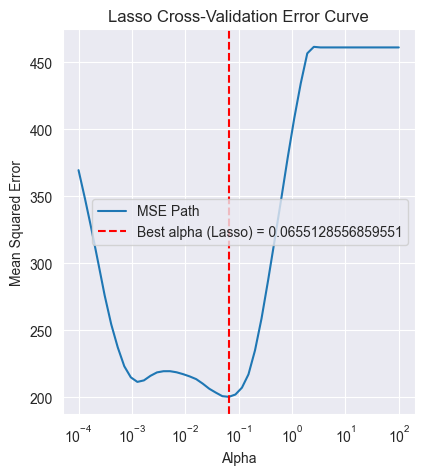

In [45]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(alphas, mean_test_error, label="MSE Path")
plt.axvline(best_alpha_lasso, color='r', linestyle='--', label=f"Best alpha (Lasso) = {best_alpha_lasso}")
plt.xscale('log')  # Logarithmic scale for alpha
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Cross-Validation Error Curve')
plt.legend()

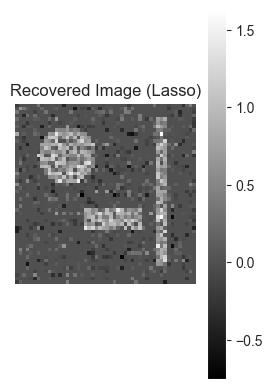

In [41]:
plt.subplot(1, 2, 2)
plt.imshow(image_lasso, cmap='gray')
plt.title('Recovered Image (Lasso)')
plt.colorbar()
plt.axis('off')
plt.show()

In [27]:
ridge = Ridge(random_state = 6740)
param_grid = {'alpha': alphas}
ridge_cv = GridSearchCV(ridge, param_grid, cv=10, n_jobs = -1, scoring='neg_mean_squared_error', return_train_score=True, verbose = 2)
ridge_cv.fit(A, y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END .......................................alpha=0.0001; total time=   0.5s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.5s
[CV] END .......................................alpha=0.0001; total time=   0.3s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.1s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................alpha=0.00013257113655901095; total time=   0.1s
[CV] END .......................alpha=0.000132

GridSearchCV(cv=10, estimator=Ridge(random_state=6740),
             param_grid={'alpha': array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.22299648e-03,
       2.94705170e-03, 3.90693994e-03, 5.17947468e-03, 6.86648845e-03,
       9.10298178e-03, 1.20679264e-02...
       2.68269580e-01, 3.55648031e-01, 4.71486636e-01, 6.25055193e-01,
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [28]:
best_alpha_ridge = ridge_cv.best_params_['alpha']
x_ridge = ridge_cv.best_estimator_.coef_
image_ridge = x_ridge.reshape((50, 50))
mean_test_error = -ridge_cv.cv_results_['mean_test_score']

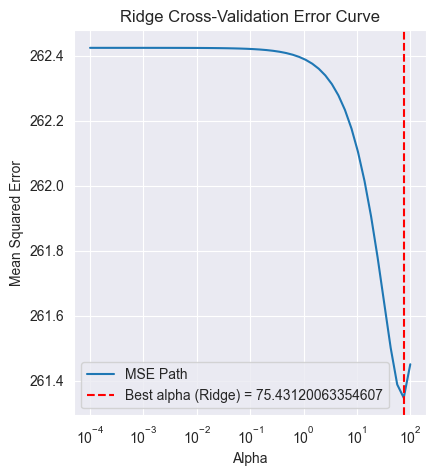

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, mean_test_error, label="MSE Path")
plt.axvline(best_alpha_ridge, color='r', linestyle='--', label=f"Best alpha (Ridge) = {best_alpha_ridge}")
plt.xscale('log')  # Logarithmic scale for alpha
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Cross-Validation Error Curve')
plt.legend()

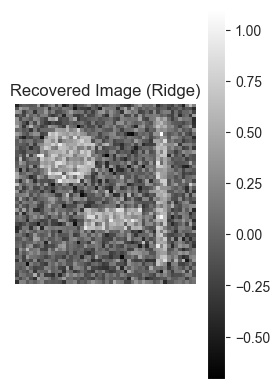

In [37]:
plt.subplot(1, 2, 2)
plt.imshow(image_ridge, cmap='gray')
plt.title(f'Recovered Image (Ridge)')
plt.colorbar()
plt.axis('off')
plt.show()
